# Predict Ratings using Review Text

This notebook consists of code that will:

1. Read a csv file containing pre-tokenized reviews. They were processed and tokenized in `Project_NLP.ipynb`.
2. Generate word vectors using Gensim Word2Vec.
3. Use word vectors to fit Random Forest, Support Vector, Logistic Regression models.
4. Use GloVe Global Vectors for word representation to fit the same models (for comparison).
5. Construct and fit a keras deep learning model to predict ratings.

# Import Python Libraries

In [119]:
#Standard Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('talk')

#Abstract Syntax Trees - used to convert dataframe review tokens that are imported as text back to lists.
import ast

#Used for timing modeling and other longer-running sections.
import time

#Used for testing classifiers
from nltk.tokenize import TweetTokenizer
from nltk.corpus import stopwords

#Gensim
import gensim
from gensim.models import Word2Vec

#Pickle
import pickle

#Sklearn
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix
from sklearn.metrics import make_scorer

#XGBoost
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'True'
from xgboost import XGBClassifier

#Keras
from keras.models import Model
from keras.layers import Input, Dense, LSTM, Embedding
from keras.layers import Dropout, GlobalMaxPool1D
from keras.preprocessing import text, sequence

# Import My Functions and Classes

In [118]:
#MY FUNCTIONS AND CLASSES
from data_modeling import load_GloVe_vectors
from data_modeling import W2vVectorizer, KerasTokenizer, KerasModel
from data_modeling import custom_accuracy
from data_modeling import get_gridsearch_result
from data_modeling import gridsearch_all_models
from data_modeling import test_the_classifier
from data_classes import phrase_clear, Review
from cf_matrix import make_confusion_matrix

In [40]:
my_scoring_function = make_scorer(custom_accuracy)

In [4]:
#Read model and model_results_df from pickle file if desired

with open("model_results.pickle","rb") as f_read:
    chosen_model, model_results_df = pickle.load(f_read)

# Read in Tokenized Reviews from file

In [5]:
reviews_df = pd.read_csv("csv_files/reviews.csv")

#Reviews are stored as one string. Need to convert to a list of strings.
reviews_df.review_tokenized = reviews_df.review_tokenized.map(ast.literal_eval)

# Set Data and Target variables

In [6]:
data = reviews_df.review_tokenized
target = reviews_df.star_rating

In [7]:
data.head()

0    [grits, know, best, take, delicious, southern,...
1    [brunch, enjoyable, mimosa, starter, eggs_bene...
2    [looking, delicious, meal, lazy_sunday, mornin...
3    [best_way_describe, shabby_chic, interior, ser...
4    [dinner_last_night, i'm_still, thinking, next_...
Name: review_tokenized, dtype: object

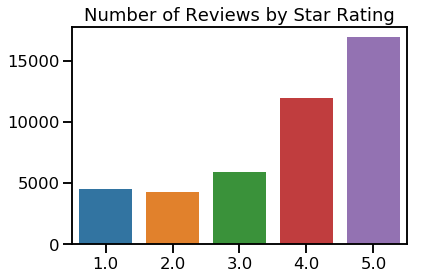

In [8]:
value_counts = target.value_counts()
sns.barplot(x=value_counts.index,y=value_counts.values);
plt.title('Number of Reviews by Star Rating');

### Clear phrases from reviews

Return reviews to original tokenized set of words - no gensim phrases. Removes underscores and re-tokenizes. Phrase clear if desired. It will reduce the vocabulary. It is also needed for GloVe vectors as they do not contain phrased words.

In [9]:
data = data.map(phrase_clear)

# Train / Test Split

Split within each star rating to ensure all rating levels are covered.

In [10]:
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size=0.1, stratify=target)

((39264,), (4363,))

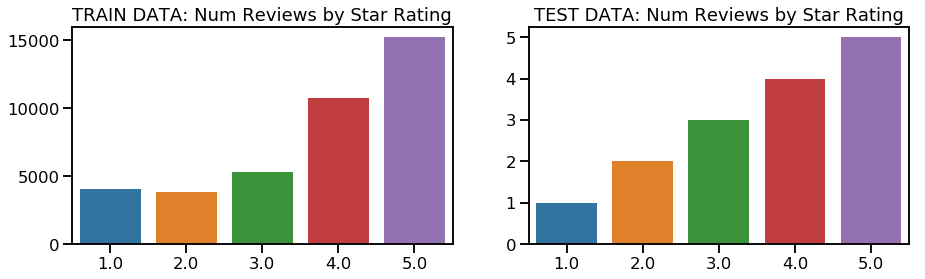

In [11]:
train_counts = y_train.value_counts()
test_counts = y_test.value_counts()

fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,4))
sns.barplot(x=train_counts.index,y=train_counts.values, ax=ax1)
sns.barplot(x=test_counts.index,y=test_counts.index, ax=ax2)
ax1.set_title('TRAIN DATA: Num Reviews by Star Rating');
ax2.set_title('TEST DATA: Num Reviews by Star Rating');

y_train.shape, y_test.shape

# Generate Word2Vec Word Embeddings

In [12]:
dim = 20 #Dimensionality of word vectors

print("Generate Word Vectors:", end=' ')
start = time.time()
model = Word2Vec(X_train,size=dim,window=5,min_count=1,workers=4)
model.train(data,total_examples=model.corpus_count,epochs=10)
end = time.time()
print(round(end-start,2),"seconds")

Generate Word Vectors: 33.41 seconds


In [13]:
#Save embedded word vector space
wv = model.wv
print(len(wv.vocab),"unique words in the dataset.")

39428 unique words in the dataset.


# Predict Ratings

## Predict Ratings using Word2Vec and several models
- Random Forest
- Support Vector Machine
- Logistic Regression
- XGBoost

In [14]:
results = []

In [15]:
#PARAMETER GRIDS FOR GRIDSEARCH
param_grid_rf  = [{'Random Forest__criterion': ['entropy'],
                   'Random Forest__max_depth': [6, 7],
                   'Random Forest__n_estimators': [100] }]

param_grid_svc = [{'Support Vector Machine__C': [1],
                   'Support Vector Machine__gamma': ['auto'] }]

param_grid_lr  = [{'Logistic Regression__solver': ['sag','lbfgs'],
                   'Logistic Regression__penalty': ['l2'],
                   'Logistic Regression__C': [.01, .1, 1],
                   'Logistic Regression__max_iter': [1000]}]

param_grid_xgb = [{'XGBoost Model__max_depth': [3],
                   'XGBoost Model__n_estimators': [100],
                   'XGBoost Model__learning_rate': [0.1, 0.2],
                   'XGBoost Model__gamma': [0, 1] }]

In [16]:
#CREATE PIPELINE MODELS AND MODELS LIST
rf  = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(wv)),
                ("Random Forest", RandomForestClassifier(max_features='auto'))])
svc = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(wv)),
                ("Support Vector Machine", SVC())])
lr  = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(wv)),
                ("Logistic Regression", LogisticRegression(multi_class='multinomial'))])
xgb = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(wv)),
                ("XGBoost Model", XGBClassifier())])

models = [("Random Forest", rf, param_grid_rf),
          ("Support Vector", svc, param_grid_svc),
          ("Logistic Regression", lr, param_grid_lr),
          ("XGBoost Model", xgb, param_grid_xgb)]

In [17]:
results.extend(gridsearch_all_models(models, X_train, X_test, y_train, y_test, scoring=my_scoring_function))

GRIDSEARCH AND SCORE ALL MODELS:
   Random Forest:	 time 00:03:01
   Support Vector:	 time 00:06:26
   Logistic Regression:	 time 00:03:24
   XGBoost Model:	 time 00:07:56
TOTAL TIME: 00:20:49


## Predict Ratings using GloVe Word Vectors and several models
- Random Forest
- Support Vector Machine
- Logistic Regression
- XGBoost

In [18]:
glove = load_GloVe_vectors(file='glove.6B.50d.txt', vocab=wv.vocab.keys())

In [19]:
#CREATE PIPELINE MODELS AND MODELS LIST
rf  = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
                ("Random Forest", RandomForestClassifier(max_features='auto'))])
svc = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
                ("Support Vector Machine", SVC())])
lr  = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
                ("Logistic Regression", LogisticRegression(multi_class='multinomial'))])
xgb = Pipeline([("Word2Vec Vectorizer", W2vVectorizer(glove)),
                ("XGBoost Model", XGBClassifier())])

glove_models = [("GloVe- Random Forest", rf, param_grid_rf),
                ("GloVe- Support Vector", svc, param_grid_svc),
                ("GloVe- Logistic Regression", lr, param_grid_lr),
                ("GloVe- XGBoost Model", xgb, param_grid_xgb)]

In [20]:
results.extend(gridsearch_all_models(glove_models, X_train, X_test, y_train, y_test, scoring=my_scoring_function))

GRIDSEARCH AND SCORE ALL MODELS:
   GloVe- Random Forest:	 time 00:03:27
   GloVe- Support Vector:	 time 00:14:14
   GloVe- Logistic Regression:	 time 00:01:54
   GloVe- XGBoost Model:	 time 00:14:46
TOTAL TIME: 00:34:23


## Predict Ratings using Keras LSTM Network Model
Neural Network using LSTM

In [21]:
embedding_size = 128
input_ = Input(shape=(100,))
x = Embedding(20000, embedding_size)(input_)
x = LSTM(25, return_sequences=True)(x)
x = GlobalMaxPool1D()(x)
x = Dropout(0.5)(x)
x = Dense(50, activation='relu')(x)
x = Dropout(0.5)(x)
# There are 5 different possible rating levels, therefore using 5 neurons in output layer
x = Dense(5, activation='softmax')(x)

keras_model = Model(inputs=input_, outputs=x)

keras_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
keras_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 100)               0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 100, 128)          2560000   
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 25)           15400     
_________________________________________________________________
global_max_pooling1d_1 (Glob (None, 25)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                1300      
_________________________________________________________________
dropout_2 (Dropout)          (None, 50)                0         
__________

In [22]:
param_grid_km  = [{'Keras LSTM Model__epochs': [2],
                   'Keras LSTM Model__batch_size': [32] }]

km  = Pipeline([("Keras Tokenizer", KerasTokenizer(num_words=20000, maxlen=100)),
                 ("Keras LSTM Model", KerasModel(keras_model))])

model = [("Keras Model", km, param_grid_km)]

In [23]:
results.extend(gridsearch_all_models(model, X_train, X_test, y_train, y_test, cv=2, scoring=my_scoring_function))

GRIDSEARCH AND SCORE ALL MODELS:
   Keras ModelTrain on 17668 samples, validate on 1964 samples
Epoch 1/2
17668/17668 [==============================] - 33s 2ms/step - loss: 1.3002 - acc: 0.4302 - val_loss: 1.0473 - val_acc: 0.5367
Epoch 2/2
17668/17668 [==============================] - 38s 2ms/step - loss: 1.0183 - acc: 0.5531 - val_loss: 0.9816 - val_acc: 0.5871
Train on 17668 samples, validate on 1964 samples
Epoch 1/2
17668/17668 [==============================] - 32s 2ms/step - loss: 1.2948 - acc: 0.4294 - val_loss: 1.0451 - val_acc: 0.5265
Epoch 2/2
17668/17668 [==============================] - 35s 2ms/step - loss: 1.0175 - acc: 0.5461 - val_loss: 0.9746 - val_acc: 0.5713
Train on 35337 samples, validate on 3927 samples
Epoch 1/2
35337/35337 [==============================] - 68s 2ms/step - loss: 1.1823 - acc: 0.4765 - val_loss: 0.9827 - val_acc: 0.5847
Epoch 2/2
35337/35337 [==============================] - 85s 2ms/step - loss: 0.9534 - acc: 0.5834 - val_loss: 0.9479 - val_ac

# View and Compare Model Results

In [24]:
model_results_df = pd.DataFrame(results)
model_results_df

,accuracy test,accuracy train,custom accuracy test,custom accuracy train,model,model params,name
0,0.5116,0.5319,0.6793,0.6936,(<data_modeling.W2vVectorizer object at 0x1c2e...,"{'Random Forest__criterion': 'entropy', 'Rando...",Random Forest
1,0.5572,0.5780,0.7321,0.7434,(<data_modeling.W2vVectorizer object at 0x1c2e...,"{'Support Vector Machine__C': 1, 'Support Vect...",Support Vector
2,0.5494,0.5486,0.7290,0.7263,(<data_modeling.W2vVectorizer object at 0x1c31...,"{'Logistic Regression__C': 1, 'Logistic Regres...",Logistic Regression
3,0.5480,0.5902,0.7219,0.7455,(<data_modeling.W2vVectorizer object at 0x1c32...,"{'XGBoost Model__gamma': 1, 'XGBoost Model__le...",XGBoost Model
4,0.4359,0.4565,0.5858,0.6038,(<data_modeling.W2vVectorizer object at 0x1c30...,"{'Random Forest__criterion': 'entropy', 'Rando...",GloVe- Random Forest
5,0.4866,0.4947,0.6545,0.6577,(<data_modeling.W2vVectorizer object at 0x1c2f...,"{'Support Vector Machine__C': 1, 'Support Vect...",GloVe- Support Vector
6,0.4946,0.5009,0.6681,0.6701,(<data_modeling.W2vVectorizer object at 0x1c2d...,"{'Logistic Regression__C': 1, 'Logistic Regres...",GloVe- Logistic Regression
7,0.4827,0.5486,0.6572,0.6979,(<data_modeling.W2vVectorizer object at 0x1c30...,"{'XGBoost Model__gamma': 1, 'XGBoost Model__le...",GloVe- XGBoost Model
8,0.5845,0.6747,0.7572,0.8201,(<data_modeling.KerasTokenizer object at 0x1c3...,"{'Keras LSTM Model__batch_size': 32, 'Keras LS...",Keras Model


In [25]:
#CHOSEN MODELS
chosen_model_keras = model_results_df.loc[8].model
chosen_model_svc = model_results_df.loc[1].model

# Confusion Matrix Comparison

In [29]:
sns.set_context('talk')

#### KERAS LSTM Model

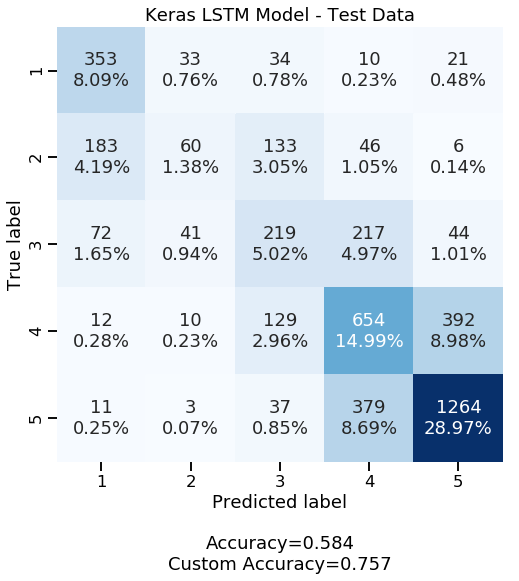

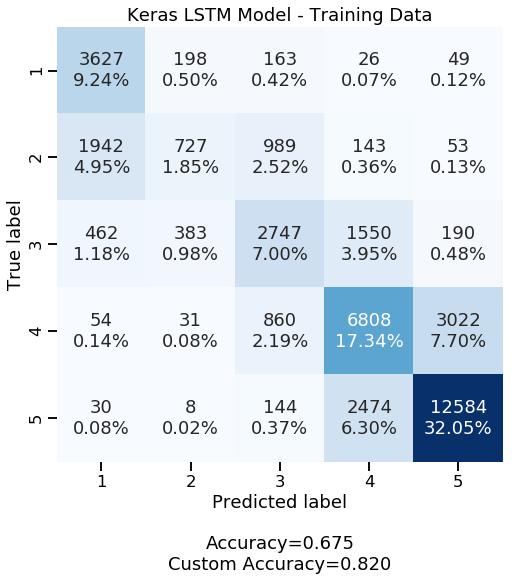

In [30]:
y_pred_test = chosen_model_keras.predict(X_test)
cf = confusion_matrix(y_test, y_pred_test)
make_confusion_matrix(cf, 
                      categories=[1,2,3,4,5], 
                      cbar=False, 
                      figsize=(8,8), 
                      title="Keras LSTM Model - Test Data",
                      custom_stat_text="Custom Accuracy",
                      custom_stat_value=custom_accuracy(y_test, y_pred_test))

y_pred_train = chosen_model_keras.predict(X_train)
cf = confusion_matrix(y_train, y_pred_train)
make_confusion_matrix(cf, 
                      categories=[1,2,3,4,5], 
                      cbar=False, 
                      figsize=(8,8), 
                      title="Keras LSTM Model - Training Data",
                      custom_stat_text="Custom Accuracy",
                      custom_stat_value=custom_accuracy(y_train, y_pred_train))

#### Support Vector Classifier Model

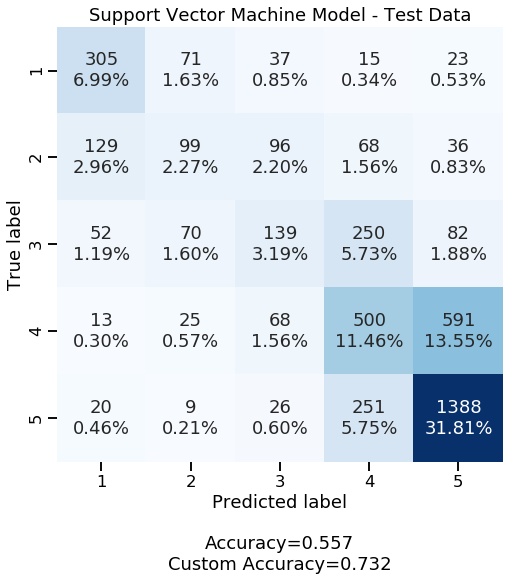

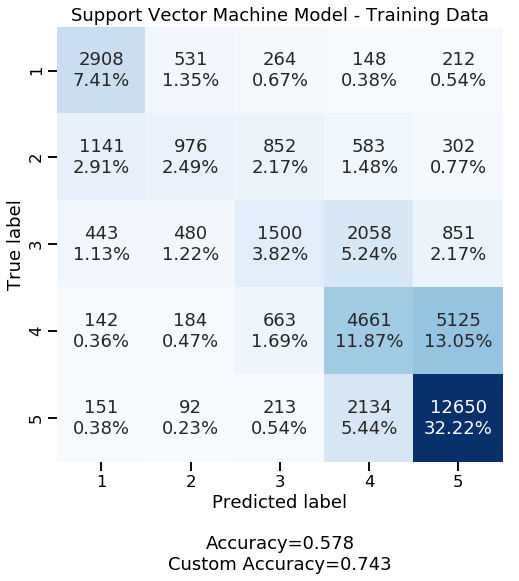

In [31]:
y_pred_test = chosen_model_svc.predict(X_test)
cf = confusion_matrix(y_test, y_pred_test)
make_confusion_matrix(cf, 
                      categories=[1,2,3,4,5], 
                      cbar=False, 
                      figsize=(8,8), 
                      title="Support Vector Machine Model - Test Data",
                      custom_stat_text="Custom Accuracy",
                      custom_stat_value=custom_accuracy(y_test, y_pred_test))
print("\n")
y_pred_train = chosen_model_svc.predict(X_train)
cf = confusion_matrix(y_train, y_pred_train)
make_confusion_matrix(cf, 
                      categories=[1,2,3,4,5], 
                      cbar=False, 
                      figsize=(8,8), 
                      title="Support Vector Machine Model - Training Data",
                      custom_stat_text="Custom Accuracy",
                      custom_stat_value=custom_accuracy(y_train, y_pred_train))

# Save Results to Pickle File

In [28]:
#SAVE RESULTS TO PICKLE FILE
with open("model_results.pickle","wb") as f_write:
    pickle.dump((chosen_model_svc, model_results_df.drop(columns=['model'])),f_write,pickle.HIGHEST_PROTOCOL)

### Test the classifier(s) for fun with random review texts of your choosing.

In [114]:
review_text_to_test = """
It was just ok. My first experience was better. 
The biscuits and gravy were dry but the burger tasted great. 
I'll give them another shot.
"""

model_to_use = chosen_model_svc

In [115]:
print(test_the_classifier(model_to_use,review_text_to_test),"stars! says the almighty classifier.")

3.0 stars! says the almighty classifier.
